# Facebook Prophet Model

# Imports

In [1]:
import sys
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import numpy as np
import math
import plotly.graph_objects as go
import plotly
import time

# To import the main.py file
sys.path.append('../')
from python_files import main

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

# Data Preprocessing Functions

In [3]:
def get_data():
    (
        confirmed_global,
        deaths_global,
        recovered_global,
        country_cases,
    ) = main.collect_data()
    recovered = recovered_global.groupby("country").sum().T
    deaths = deaths_global.groupby("country").sum().T
    confirmed = confirmed_global.groupby("country").sum().T

    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
    recovered.index = pd.to_datetime(recovered.index, infer_datetime_format=True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)

    return deaths, recovered, confirmed

In [4]:
def create_data_frame(df_name="confirmed", country="US"):
    deaths, recovered, confirmed = get_data()
    if df_name == "deaths":
        data = pd.DataFrame(
            index=deaths.index, data=deaths[country].values, columns=["Total"]
        )

    elif df_name == "recovered":
        data = pd.DataFrame(
            index=recovered.index, data=recovered[country].values, columns=["Total"]
        )

    elif df_name == "confirmed":
        data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )

    data = data[(data != 0).all(1)]

    data["Date"] = data.index
    cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
    data = data[cols]
    data.columns = ["ds", "y"]
    return data

# Model Functions

In [5]:
def build_model():
    prophet = (
        Prophet(
            growth="linear",
            seasonality_mode="additive",
            changepoint_prior_scale=30,
            seasonality_prior_scale=35,
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
        )
        .add_seasonality(name="monthly", period=30.5, fourier_order=55)
        .add_seasonality(name="weekly", period=7, fourier_order=15)
        .add_seasonality(name="daily", period=1, fourier_order=15)
    )

    return prophet

In [6]:
def predict_future(prophet,data):
    prophet.fit(data)
    future = prophet.make_future_dataframe(freq="D", periods=14)
    forecast = prophet.predict(future)
    ftr = pd.Series(
        data=forecast[len(data) :]["yhat"].values, index=forecast[len(data) :]["ds"]
    )
    ftr.columns = ["Total"]
    ftr.index.freq = "D"
    for i in range(len(ftr)):
        if(ftr[i]%1>=0.5):
            ftr[i]=math.ceil(ftr[i])
        else:
            ftr[i]=int(ftr[i])
    return ftr

# Graphing Function

In [7]:
def plot_forecast(data,forecast):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=data["ds"], y=data["y"], mode="lines", name="Up till now ")
    )

    fig.add_trace(
        go.Scatter(
            x=forecast.index, y=forecast.values, mode="lines", name="Prediction*"
        )
    )

    fig.update_layout(
        title={
            "text": "Forecasted results",
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        template="plotly_dark",
        xaxis_title="Date",
        yaxis_title="Cases",
        legend_title="Legend ",
        font=dict(family="Arial", size=15, color="white"),
    )
    return fig

# Error Function

In [8]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Main Function

In [9]:
def prophet_predict(df_name="confirmed", country="US"):
    data = create_data_frame(df_name, country)
    prophet = build_model()
    ftr = predict_future(prophet, data)
    fig = plot_forecast(data, ftr)
    df_cv = cross_validation(
        prophet, initial=f"{0.8*len(data)} days", period="7 days", horizon="14 days"
    )
    for i in range(len(df_cv)):
        df_cv.yhat.values[i] = int(df_cv.yhat.values[i])
    error = mape(df_cv.y, df_cv.yhat)
    return fig, error

# Example

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-09-25 00:00:00 and 2020-11-06 00:00:00


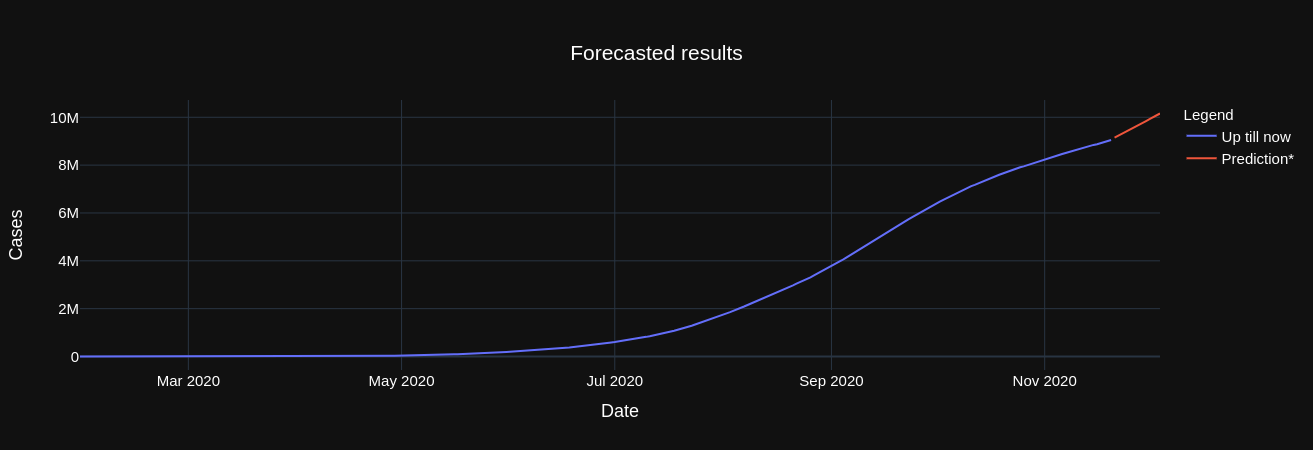

Allow an error upto 1.72%
Time taken to forecast was 73.57320666313171 seconds


In [10]:
start = time.time()
fig, error = prophet_predict("confirmed", "India")
end = time.time()
fig.show()
print(f"Allow an error upto {round(error, 2)}%")
print(f"Time taken to forecast was {end-start} seconds")